In [3]:
# Pre-compute values of the A B and C integrals

import numpy as np
import scipy as sp
import time
# import pint  # not actually using (yet)
from scipy import integrate
import matplotlib.pyplot as plt

import shelve

import InterpolateParams
import PrecomputeParams
import EFTParams
import Integrands
import Wavefunctions
import importlib
importlib.reload(InterpolateParams)
importlib.reload(PrecomputeParams)
importlib.reload(EFTParams)
importlib.reload(Integrands)
importlib.reload(Wavefunctions)

from collections import defaultdict

# import os 
# base_path = os.path.dirname(os.getcwd())

In [11]:
# Check on complex phases of various parameters
wf_string = "LLL_jit"
mi =  ((0,),(0,),(0,),(0,))
param_type = "O"
H = 1
results_precomp = PrecomputeParams.get_param_precomputed(wf_string, mi, param_type, H)[0]

print(results_precomp)

(-0.12116557049905807-0.11878984760121067j)


In [16]:
# Single parameter value from spline
# Try out InterpolateParams on O
wf_string = "LLL_jit"
pt = "O"
a=6
b=6
c=3
d=9
mi =  ((a,),(b,),(c,),(d,))
H = 1e-3

results = InterpolateParams.get_param_from_spline(wf_string, mi, pt, H)
print(results)

Using old spline
(-0.03700824941901739+0.03879203482617086j)


Calculating new spline


Text(0.5,0,'H')

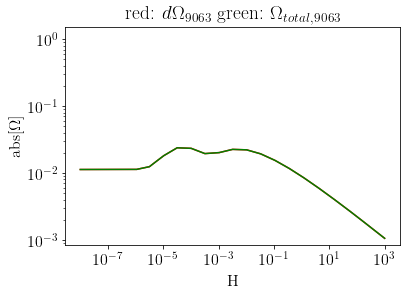

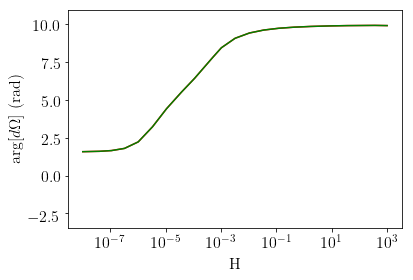

In [34]:
# Try out InterpolateParams on O
wf_string = "LLL_jit"
a=9
b=0
c=6
d=3
mi =  ((a,),(b,),(c,),(d,))

param_type = "O"
Hspline = 10**np.linspace(-8, 3, num=1000)
results = InterpolateParams.get_param_from_spline(wf_string, mi, param_type, Hspline)
results_total_coupling = results + ((a==c)*(b==d)+(a==d)*(b==c))/np.sqrt(1+(a==b))

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=16)

plt.loglog(Hspline, np.abs(results), '-r', Hspline, np.abs(results_total_coupling), '-g')
plt.ylabel('abs[$\Omega$]')
plt.xlabel('H')
plt.ylim(np.minimum(0.8*np.min(np.abs(results)), 10**-2), np.maximum(1.5, 1.2*np.max(np.abs(results))))
plt.title("red: $d\Omega_{" + str(a) +  str(b) + str(c) + str(d) + "}$      green: $\Omega_{total," + str(a) +  str(b) + str(c) + str(d) + "}$")
plt.figure()
plt.semilogx(Hspline, np.unwrap(np.angle(results)), '-r',  Hspline, np.unwrap(np.angle(results_total_coupling)), '-g')
plt.ylim(np.minimum(np.min(ang)*1.1, -1), np.maximum(1, 1.1*np.max(np.unwrap(np.angle(results)))))
plt.ylabel('arg[$d\Omega$] (rad)')
plt.xlabel('H')

Calculating new spline


Text(0.5,0,'H')

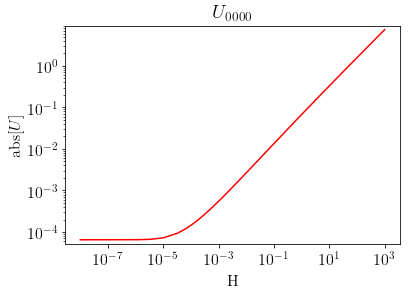

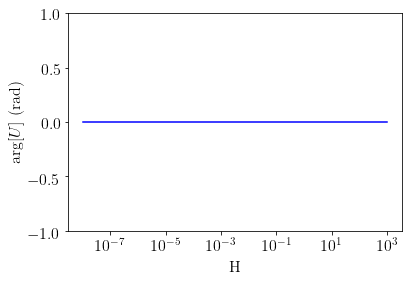

In [17]:
# Try out InterpolateParams on U
wf_string = "LLL_jit"
mi =  ((0,),)*4
# mi =  ((9,),(0,),(6,),(3,),)
# mi =  ((3,),(3,),(6,),(0,),)
param_type = "U"
Hspline = 10**np.linspace(-8, 3, num=1000)
results = InterpolateParams.get_param_from_spline(wf_string, mi, param_type, Hspline)

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=16)

plt.loglog(Hspline, np.abs(results), '-r')
plt.ylabel('abs[$U$]')
plt.xlabel('H')
plt.ylim(np.minimum(0.8*np.min(np.abs(results)), 10**-3), np.maximum(1, 1.2*np.max(np.abs(results))))
plt.title("$U_{" + str(mi[0][0]) +  str(mi[1][0]) + str(mi[2][0]) + str(mi[3][0]) + "}$")
plt.figure()
ang = np.unwrap(np.angle(results))
plt.semilogx(Hspline, ang, '-b')
plt.ylim(np.minimum(np.min(ang)*1.1, -1), np.maximum(1, 1.1*np.max(ang)))
plt.ylabel('arg[$U$] (rad)')
plt.xlabel('H')

In [14]:
# First veery basic tests of PrecomputeParams

wf_string = "LLL_jit"
# mi = ((6,),(3,)) # ((9,),(0,))
# pt = "G"
mi =  ((9,),(0,),(6,),(3,))
# mi =  ((3,),(3,),(3,),(3,))
pt = "B"
Hs = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

key = (wf_string, mi, pt)

for H in Hs:
    print(PrecomputeParams.get_param_precomputed(wf_string, mi, pt, H, tol_rel=10**-1, force_compute=False, epsabs=1.49e-08, epsrel=0.1))
    

((-341.907476542674-257.7644659363491j), False)
((430.11497431315627-157.2216224531679j), False)
((-8.879731570756462+158.0561636638341j), False)
((-15.466009024452134-10.19366315544356j), False)
((-0.01884364012564956-2.2166388233677523j), False)
((0.051282048432347294-0.16487989059428543j), False)


In [63]:
# Pre-compute a bunch of values! Version 2

wf_string = "LLL_jit"

pts = ["U", "O"] # the two types of parameters to calculate; calculating U and O ends up calculating the required integrals A B and C as factors in the U and O calculations

Hexp_start = -8
Hexp_end = 3
pts_per_decade = 2

force_compute = False

modes = [0, 1, 2, 3]

Hexps = np.linspace(Hexp_start, Hexp_end, num=pts_per_decade*(Hexp_end-Hexp_start)+1)

tic = time.time_ns()
how_many = 0
times = []


for Hexp in Hexps:
    tich = time.time_ns()
    H = 10**Hexp
    for m1 in modes:
        for m2 in modes:
            for m3 in modes:
                for m4 in modes:
                    for pt in pts:
                        mi = ((m1,), (m2,), (m3,), (m4,)) # get_param_precomputed will detect redundancies automatically
                        
                        # Pass a real H for now; it becomes imaginary in the cuts of PrecomputeParams
                        

                        result = PrecomputeParams.get_param_precomputed(wf_string, mi, pt, H, tol_rel=10**-1, force_compute=force_compute, epsabs=1.49e-08, epsrel=0.1)

#                         print("For H = " + str(H) + ", mi = " + str(mi) + ", parameter " + pt + " = " + str(result))

                        how_many += 1
                        toc = time.time_ns()

                        times.append((toc-tic)/10**9)
        print("So far calculated " + str(how_many) + " parameters in a total of " + str((toc-tic)/10**9) + " seconds")
        print("")
    print("Finished H = " + str(H) + " in " + str((toc-tich)/10**9) + " seconds")
    print("")
            
        

C:\Users\Logan\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


So far calculated 128 parameters in a total of 231.8195704 seconds

So far calculated 256 parameters in a total of 340.8867291 seconds



C:\Users\Logan\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


So far calculated 384 parameters in a total of 516.0470146 seconds

So far calculated 512 parameters in a total of 520.1931948 seconds

Finished H = 1e-08 in 520.1931948 seconds

So far calculated 640 parameters in a total of 689.0028443 seconds

So far calculated 768 parameters in a total of 814.7810526 seconds

So far calculated 896 parameters in a total of 1069.0228139 seconds

So far calculated 1024 parameters in a total of 1073.083739 seconds

Finished H = 3.162277660168379e-08 in 552.8905442 seconds

So far calculated 1152 parameters in a total of 1242.0764838 seconds

So far calculated 1280 parameters in a total of 1343.4033513 seconds

So far calculated 1408 parameters in a total of 1477.8670456 seconds

So far calculated 1536 parameters in a total of 1481.9966436 seconds

Finished H = 1e-07 in 408.9129046 seconds

So far calculated 1664 parameters in a total of 1602.1017383 seconds

So far calculated 1792 parameters in a total of 1704.9038292 seconds

So far calculated 1920 pa

C:\Users\Logan\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


So far calculated 10880 parameters in a total of 10269.3584503 seconds

So far calculated 11008 parameters in a total of 10719.8447115 seconds

So far calculated 11136 parameters in a total of 10955.1631668 seconds

So far calculated 11264 parameters in a total of 10960.292455 seconds

Finished H = 316.22776601683796 in 1072.4265898 seconds

So far calculated 11392 parameters in a total of 11380.0538767 seconds

So far calculated 11520 parameters in a total of 11910.9069652 seconds

So far calculated 11648 parameters in a total of 12163.4382264 seconds

So far calculated 11776 parameters in a total of 12168.7440528 seconds

Finished H = 1000.0 in 1208.4515978 seconds



In [45]:
# Pre-compute a bunch of values! Version 2 [TEMPORARY EXTRA for running more after the regular one is done]

wf_string = "LLL_jit"

pts = ["U", "O"] # the two types of parameters to calculate; calculating U and O ends up calculating the required integrals A B and C as factors in the U and O calculations

Hexp_start = -8
Hexp_end = 3
pts_per_decade = 4

force_compute = False

modes = [0, 1, 2, 3]

Hexps = np.linspace(Hexp_start, Hexp_end, num=pts_per_decade*(Hexp_end-Hexp_start)+1)

tic = time.time_ns()
how_many = 0
times = []


for Hexp in Hexps:
    tich = time.time_ns()
    H = 10**Hexp
    for m1 in modes:
        for m2 in modes:
            for m3 in modes:
                for m4 in modes:
                    for pt in pts:
                        mi = ((m1,), (m2,), (m3,), (m4,)) # get_param_precomputed will detect redundancies automatically
                        
                        # Pass a real H for now; it becomes imaginary in the cuts of PrecomputeParams
                        

                        result = PrecomputeParams.get_param_precomputed(wf_string, mi, pt, H, tol_rel=10**-1, force_compute=force_compute, epsabs=1.49e-08, epsrel=0.1)

#                         print("For H = " + str(H) + ", mi = " + str(mi) + ", parameter " + pt + " = " + str(result))

                        how_many += 1
                        toc = time.time_ns()

                        times.append((toc-tic)/10**9)
        print("So far calculated " + str(how_many) + " parameters in a total of " + str((toc-tic)/10**9) + " seconds")
        print("")
    print("Finished H = " + str(H) + " in " + str((toc-tich)/10**9) + " seconds")
    print("")
            
        

So far calculated 128 parameters in a total of 3.7838683 seconds

So far calculated 256 parameters in a total of 7.5855415 seconds

So far calculated 384 parameters in a total of 11.2987814 seconds

So far calculated 512 parameters in a total of 16.0508017 seconds

Finished H = 1e-08 in 16.0508017 seconds

So far calculated 640 parameters in a total of 25.7783341 seconds

So far calculated 768 parameters in a total of 33.1110239 seconds

So far calculated 896 parameters in a total of 40.0258525 seconds

So far calculated 1024 parameters in a total of 45.0401046 seconds

Finished H = 1.7782794100389228e-08 in 28.9893029 seconds

So far calculated 1152 parameters in a total of 48.6046485 seconds

So far calculated 1280 parameters in a total of 52.1242983 seconds

So far calculated 1408 parameters in a total of 56.8767591 seconds

So far calculated 1536 parameters in a total of 60.8238767 seconds

Finished H = 3.162277660168379e-08 in 15.7827749 seconds

So far calculated 1664 parameters 

ZeroDivisionError: division by zero

In [10]:
# Pre-compute a bunch of values! Version 2 [TEMPORARY EXTRA for running more after the regular one is done]

wf_string = "LLL_jit"

pts = ["U", "O"] # the two types of parameters to calculate; calculating U and O ends up calculating the required integrals A B and C as factors in the U and O calculations

Hexp_start = -6
Hexp_end = -4
pts_per_decade = 8

force_compute = False

modes = [0, 1, 2, 3]

Hexps = np.linspace(Hexp_start, Hexp_end, num=pts_per_decade*(Hexp_end-Hexp_start)+1) # [-5.0] # np.linspace(Hexp_start, Hexp_end, num=pts_per_decade*(Hexp_end-Hexp_start)+1)

tic = time.time_ns()
how_many = 0
times = []


for Hexp in Hexps:
    tich = time.time_ns()
    H = 10**Hexp
    for m1 in modes:
        for m2 in modes:
            for m3 in modes:
                for m4 in modes:
                    for pt in pts:
                        mi = ((m1,), (m2,), (m3,), (m4,)) # get_param_precomputed will detect redundancies automatically
                        
                        # Pass a real H for now; it becomes imaginary in the cuts of PrecomputeParams
                        

                        result = PrecomputeParams.get_param_precomputed(wf_string, mi, pt, H, tol_rel=10**-1, force_compute=force_compute, epsabs=1.49e-08, epsrel=0.1)

#                         print("For H = " + str(H) + ", mi = " + str(mi) + ", parameter " + pt + " = " + str(result))

                        how_many += 1
                        toc = time.time_ns()

                        times.append((toc-tic)/10**9)
        print("So far calculated " + str(how_many) + " parameters in a total of " + str((toc-tic)/10**9) + " seconds")
        print("")
    print("Finished H = " + str(H) + " in " + str((toc-tich)/10**9) + " seconds")
    print("")
            
        

So far calculated 128 parameters in a total of 3.2398322 seconds

So far calculated 256 parameters in a total of 6.8027733 seconds

So far calculated 384 parameters in a total of 10.0261879 seconds

So far calculated 512 parameters in a total of 13.262401 seconds

Finished H = 1e-06 in 13.262401 seconds

So far calculated 640 parameters in a total of 16.642584 seconds

So far calculated 768 parameters in a total of 20.0046442 seconds

So far calculated 896 parameters in a total of 23.4082724 seconds

So far calculated 1024 parameters in a total of 26.7948437 seconds

Finished H = 1.333521432163324e-06 in 13.5324427 seconds

So far calculated 1152 parameters in a total of 30.007723 seconds

So far calculated 1280 parameters in a total of 33.2218816 seconds

So far calculated 1408 parameters in a total of 36.714806 seconds

So far calculated 1536 parameters in a total of 40.1508035 seconds

Finished H = 1.778279410038923e-06 in 13.3559598 seconds

So far calculated 1664 parameters in a t

In [12]:
# Pre-compute a bunch of values! Version 2 [TEMPORARY EXTRA for running more after the regular one is done]

wf_string = "LLL_jit"

pts = ["U", "O"] # the two types of parameters to calculate; calculating U and O ends up calculating the required integrals A B and C as factors in the U and O calculations

Hexp_start = -8
Hexp_end = 3
pts_per_decade = 16

force_compute = False

modes = [0, 3, 6, 9]

Hexps = np.linspace(Hexp_start, Hexp_end, num=pts_per_decade*(Hexp_end-Hexp_start)+1)

tic = time.time_ns()
how_many = 0
times = []


for Hexp in Hexps:
    tich = time.time_ns()
    H = 10**Hexp
    for m1 in modes:
        for m2 in modes:
            for m3 in modes:
                for m4 in modes:
                    for pt in pts:
                        mi = ((m1,), (m2,), (m3,), (m4,)) # get_param_precomputed will detect redundancies automatically
                        
                        # Pass a real H for now; it becomes imaginary in the cuts of PrecomputeParams
                        

                        result = PrecomputeParams.get_param_precomputed(wf_string, mi, pt, H, tol_rel=10**-1, force_compute=force_compute, epsabs=1.49e-08, epsrel=0.1)

#                         print("For H = " + str(H) + ", mi = " + str(mi) + ", parameter " + pt + " = " + str(result))

                        how_many += 1
                        toc = time.time_ns()

                        times.append((toc-tic)/10**9)
        print("So far calculated " + str(how_many) + " parameters in a total of " + str((toc-tic)/10**9) + " seconds")
        print("")
    print("Finished H = " + str(H) + " in " + str((toc-tich)/10**9) + " seconds")
    print("")
            

So far calculated 128 parameters in a total of 3.2175515 seconds

So far calculated 256 parameters in a total of 6.2592806 seconds

So far calculated 384 parameters in a total of 9.3597787 seconds

So far calculated 512 parameters in a total of 12.3824052 seconds

Finished H = 1e-08 in 12.3824052 seconds

So far calculated 640 parameters in a total of 17.7473537 seconds

So far calculated 768 parameters in a total of 22.8178159 seconds

So far calculated 896 parameters in a total of 27.0641 seconds

So far calculated 1024 parameters in a total of 30.8938902 seconds

Finished H = 1.1547819846894582e-08 in 18.511485 seconds

So far calculated 1152 parameters in a total of 34.2597707 seconds

So far calculated 1280 parameters in a total of 37.5369893 seconds

So far calculated 1408 parameters in a total of 41.8201038 seconds

So far calculated 1536 parameters in a total of 45.4497405 seconds

Finished H = 1.333521432163324e-08 in 14.5558503 seconds

So far calculated 1664 parameters in a 

KeyboardInterrupt: 

In [ ]:
# Delete all of the O parameter values
# should be able to recalculate without any actual integrals
